# Advanced Large Scale learning with ModelSelector
Very often we have many different products, regions, countries, shops...for which we need to delivery forecast. This can be easily done with `ModelSelector`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.model_selection import ModelSelector
from hcrystalball.utils import get_sales_data
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Get Dummy Data

In [3]:
df = get_sales_data(n_dates=365*2, 
                    n_assortments=2, 
                    n_states=2, 
                    n_stores=2)

In [4]:
df.head()

,Store,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2,State,HolidayCode
Date,,,,,,,,,,
2013-08-01,817,25013,True,True,True,a,a,False,BE,DE-BE
2013-08-01,251,18633,True,True,True,a,c,False,NW,DE-NW
2013-08-01,335,16324,True,True,True,b,a,True,NW,DE-NW
2013-08-01,380,15092,True,True,True,a,a,True,NW,DE-NW
2013-08-01,788,19788,True,True,True,a,c,False,BE,DE-BE


### Get predefined sklearn models, holidays and exogenous variables
Here for the sake of time, we will use the advantage of the ``create_gridsearch`` method for cv splits, default scorer etc. and just extend empty grid with two models

In [5]:
ms = ModelSelector(frequency='D', horizon=10, country_code_column='HolidayCode')

In [6]:
# see full default parameter grid in hands on exercise
ms.create_gridsearch(
    n_splits=2,
    between_split_lag=5, # create overlapping cv_splits
    sklearn_models=False,
    sklearn_models_optimize_for_horizon=False,
    autosarimax_models=False,
    prophet_models=False,
    tbats_models=False,
    exp_smooth_models=False,
    average_ensembles=False,
    stacking_ensembles=False,
    exog_cols=['Open','Promo','SchoolHoliday','Promo2'],
)

In [7]:
ms.add_model_to_gridsearch(get_sklearn_wrapper(LinearRegression))
ms.add_model_to_gridsearch(get_sklearn_wrapper(RandomForestRegressor))

### Run model selection with partitions
This can be done within classical for loop that enables you to see progress bar, or within parallelized prefect flow in case you would define `parallel_over_columns`, which must be subset of `partition_columns` and optionally add `executor` to point to your running `dask` cluster. Default uses `LocalExecutor`, you might also try `LocalDaskExecutor`, that prefect will spin up for you `DaskExecutor` if you have one already running and you want to connect to it.

In [8]:
df

,Store,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,Promo2,State,HolidayCode
Date,,,,,,,,,,
2013-08-01,817,25013,True,True,True,a,a,False,BE,DE-BE
2013-08-01,251,18633,True,True,True,a,c,False,NW,DE-NW
2013-08-01,335,16324,True,True,True,b,a,True,NW,DE-NW
2013-08-01,380,15092,True,True,True,a,a,True,NW,DE-NW
2013-08-01,788,19788,True,True,True,a,c,False,BE,DE-BE
...,...,...,...,...,...,...,...,...,...,...
2015-07-31,523,15349,True,True,True,c,c,False,BE,DE-BE
2015-07-31,513,19959,True,True,True,a,a,False,BE,DE-BE
2015-07-31,380,17133,True,True,True,a,a,True,NW,DE-NW


In [9]:
# from prefect.engine.executors import LocalDaskExecutor
ms.select_model(df=df,
                target_col_name='Sales',
                partition_columns=['Assortment', 'State', 'Store'],               
#                 parallel_over_columns=['Assortment'],
#                 executor = LocalDaskExecutor(),
               )

In [10]:
ms.get_partitions(as_dataframe=True)

,Assortment,State,Store
0,a,BE,513
1,a,BE,817
2,a,NW,335
3,a,NW,380
4,c,BE,523
5,c,BE,788
6,c,NW,251
7,c,NW,756


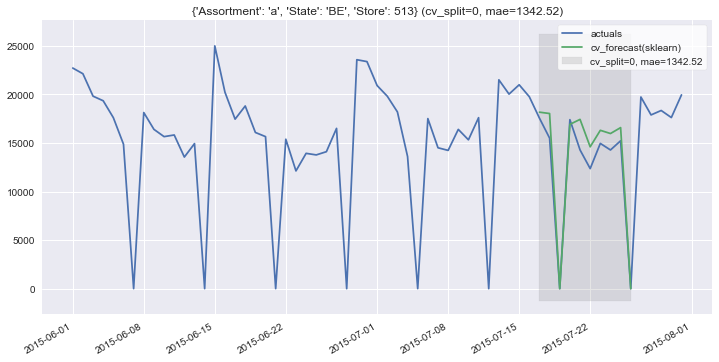

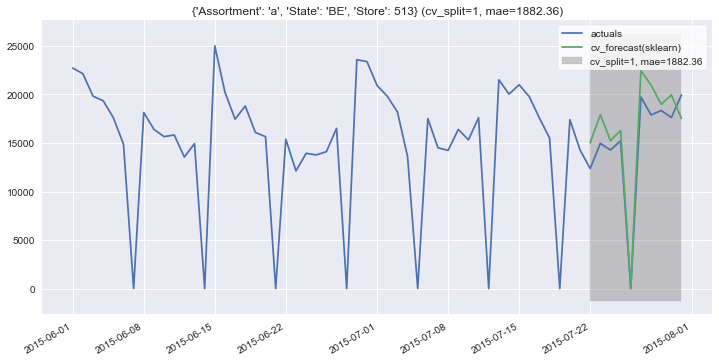

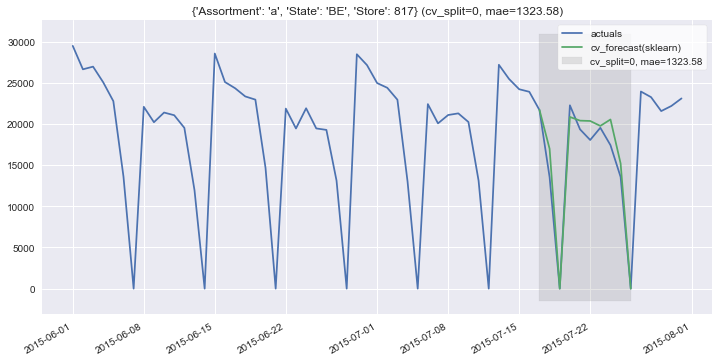

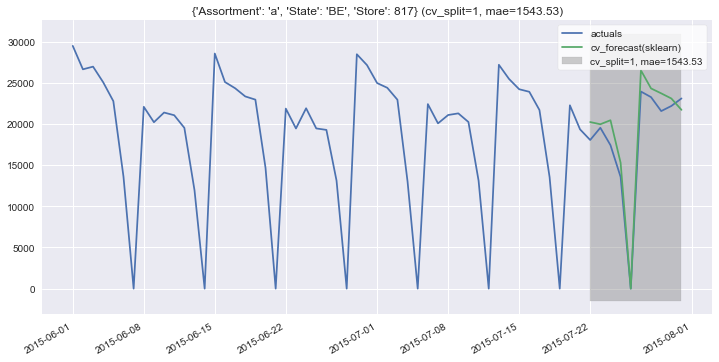

In [11]:
ms.plot_results(partitions=ms.partitions[:2], plot_from='2015-06');